In [1]:
import torch
from torchvision import models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import numpy as np

from tqdm import tqdm

In [ ]:
!micromamba activate nlp

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name()

'Tesla V100S-PCIE-32GB'

In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [12]:
def get_model():
    # Загрузка модели ResNet50
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Убираем последний полносвязный слой (FC)
    model.fc = torch.nn.Identity()

    # Выключаем вычисление градиентов и включаем режим оценки
    for param in model.parameters():
        param.requires_grad = False
    model.eval()

    model = model.to(DEVICE)
    return model

In [13]:
# Трансформация изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Теперь делаем изображение трёхканальным
    transforms.ToTensor(),
])

# Загрузка FashionMNIST
dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)

In [14]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [15]:
model = get_model()

In [17]:
# Извлекаем признаки
features_list = []
labels_list = []

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(DEVICE)
        outputs = model(images)
        images = images.to(torch.device('cpu'))
        features_list.append(outputs.cpu().numpy())
        labels_list.append(labels.numpy())

# Обрабатываем полученные признаки и метки
all_features = np.concatenate(features_list, axis=0)
all_labels = np.concatenate(labels_list, axis=0)

100%|██████████| 938/938 [02:42<00:00,  5.79it/s]


In [18]:
print("Размер массива признаков:", all_features.shape)
print("Количество классов:", len(np.unique(all_labels)))

Размер массива признаков: (60000, 2048)
Количество классов: 10


In [20]:
import pickle


with open('fashionmnist_features.pkl', 'wb') as f:
    pickle.dump(all_features, f)


with open('fashionmnist_labels.pkl', 'wb') as f:
    pickle.dump(all_labels, f)

print("Признаки успешно сохранены!")

Признаки успешно сохранены!


In [ ]:
item = all_features[0]
item

array([0.313766  , 0.        , 0.79336053, ..., 0.02428298, 0.        ,
       0.3062309 ], shape=(2048,), dtype=float32)

# Вектоный поиск

In [24]:
!pip install faiss-cpu

Looking in indexes: https://nexus-docker-proxy.biotech.biotc.ru/repository/pypi-all/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 68.4 MB/s  0:00:00m0:00:01


In [25]:
import faiss

In [26]:
norm_all_features = all_features / np.linalg.norm(all_features, axis=1, keepdims=True)


In [28]:
norm_all_features[0]

array([0.01982925, 0.        , 0.05013845, ..., 0.00153462, 0.        ,
       0.01935305], shape=(2048,), dtype=float32)

In [29]:
index = faiss.IndexFlatL2(norm_all_features.shape[1])

In [30]:
index.add(norm_all_features)

In [90]:
K = 10

def search_nearest_neighbors(i):
    """
    Функция поиска ближайших соседей.
    :param query_vector: Вектор-запрос (предварительно нормализованный!)
    :param k: Количество ближайших соседей
    :return: индексы ближайших соседей и расстояния до них
    """
    query_vector = norm_all_features[i].reshape(1, -1)
    
    distances, indices = index.search(query_vector.reshape(1, -1), K)
    return indices.flatten(), distances.flatten()

In [91]:
nearest_indices, nearest_distances = search_nearest_neighbors(0)

CURRENT_ITEM = 0

print("Индексы ближайших соседей:", nearest_indices)
print("Расстояния до ближайших соседей:", nearest_distances)

Индексы ближайших соседей: [    0 50124 20525 27125 19681 43823 41025 42044 19684 11872]
Расстояния до ближайших соседей: [0.         0.1723772  0.17792296 0.18009254 0.18308404 0.18316257
 0.18481298 0.18615171 0.18699257 0.18758763]


In [92]:
from matplotlib import pyplot as plt


def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    plt_ax.imshow(inp.permute(1, 2, 0))
    plt_ax.grid(False)


def preview(images, labels, rows=3, cols=3):
    """Предпросмотр первых изображений из набора."""
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))  # Создаем сетку для отображения изображений
    num_images = min(len(images), rows*cols)  # Ограничиваем количество отображаемых изображений
    for idx in range(num_images):
        row_idx = idx // cols
        col_idx = idx % cols
        ax = axes[row_idx][col_idx]
        imshow(images[idx], title=f"{labels[idx]}", plt_ax=ax)  # Отображаем изображение с подписью класса
    plt.show()

In [93]:
images = []
labels = []

for i in nearest_indices[1:]:
    images.append(dataset[i][0])
    labels.append(dataset[i][1])

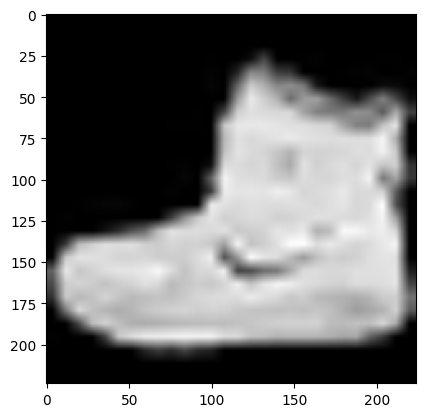

In [94]:
current_image = dataset[CURRENT_ITEM][0].permute(1, 2, 0)

plt.imshow(current_image)
plt.show()

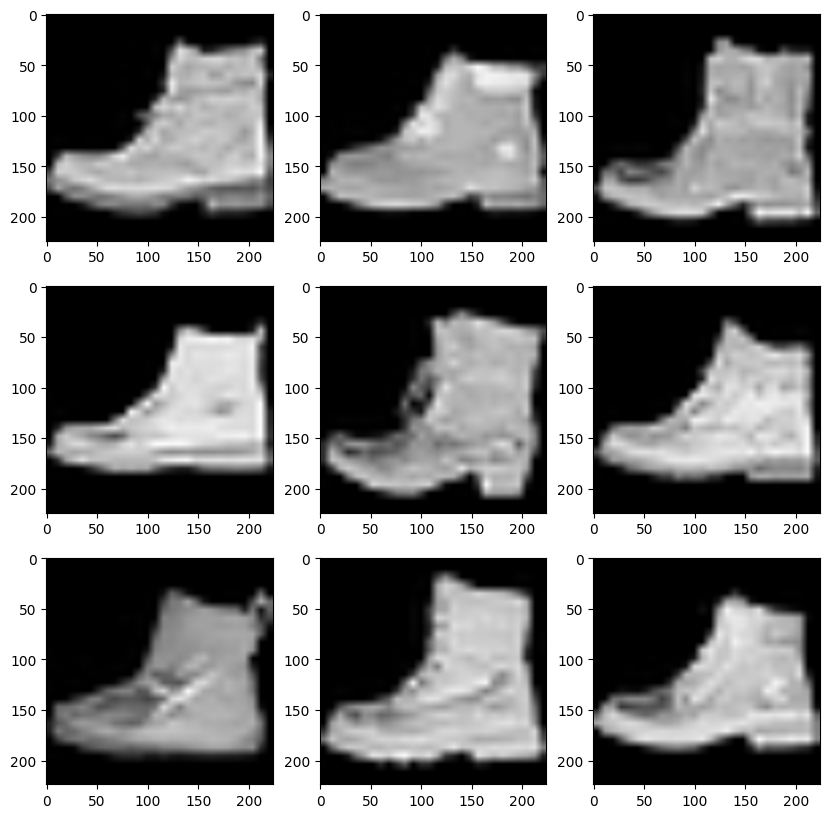

In [95]:
preview(images, labels)